# Deep Reinforcement learning with parameter fitting

---



---


### Student ID: u2016609
### Celia Xi


# replay_buffer



ReplayBuffer, which is commonly used in reinforcement learning to store and sample experiences (transitions). It initializes a buffer for each agent to store observations, actions, rewards, next observations, and done flags, with capacities defined by the buffer_size. It provides methods to store new transitions into the buffer and sample a batch of transitions for training purposes. The sampling is random without replacement to ensure a diverse set of experiences for batch updates. This approach is essential for stabilizing and improving the training process of reinforcement learning agents.



In [ ]:
import torch
import numpy as np


class ReplayBuffer(object):
    def __init__(self, args):
        self.N = args.N  # The number of agents
        self.buffer_size = args.buffer_size
        self.batch_size = args.batch_size
        self.count = 0
        self.current_size = 0
        self.buffer_obs_n, self.buffer_a_n, self.buffer_r_n, self.buffer_s_next_n, self.buffer_done_n = [], [], [], [], []
        for agent_id in range(self.N):
            self.buffer_obs_n.append(np.empty((self.buffer_size, args.obs_dim_n[agent_id])))
            self.buffer_a_n.append(np.empty((self.buffer_size, args.action_dim_n[agent_id])))
            self.buffer_r_n.append(np.empty((self.buffer_size, 1)))
            self.buffer_s_next_n.append(np.empty((self.buffer_size, args.obs_dim_n[agent_id])))
            self.buffer_done_n.append(np.empty((self.buffer_size, 1)))

    def store_transition(self, obs_n, a_n, r_n, obs_next_n, done_n):
        for agent_id in range(self.N):
            self.buffer_obs_n[agent_id][self.count] = obs_n[agent_id]
            self.buffer_a_n[agent_id][self.count] = a_n[agent_id]
            self.buffer_r_n[agent_id][self.count] = r_n[agent_id]
            self.buffer_s_next_n[agent_id][self.count] = obs_next_n[agent_id]
            self.buffer_done_n[agent_id][self.count] = done_n[agent_id]
        self.count = (self.count + 1) % self.buffer_size  # When the 'count' reaches max_size, it will be reset to 0.
        self.current_size = min(self.current_size + 1, self.buffer_size)

    def sample(self, ):
        index = np.random.choice(self.current_size, size=self.batch_size, replace=False)
        batch_obs_n, batch_a_n, batch_r_n, batch_obs_next_n, batch_done_n = [], [], [], [], []
        for agent_id in range(self.N):
            batch_obs_n.append(torch.tensor(self.buffer_obs_n[agent_id][index], dtype=torch.float))
            batch_a_n.append(torch.tensor(self.buffer_a_n[agent_id][index], dtype=torch.float))
            batch_r_n.append(torch.tensor(self.buffer_r_n[agent_id][index], dtype=torch.float))
            batch_obs_next_n.append(torch.tensor(self.buffer_s_next_n[agent_id][index], dtype=torch.float))
            batch_done_n.append(torch.tensor(self.buffer_done_n[agent_id][index], dtype=torch.float))

        return batch_obs_n, batch_a_n, batch_r_n, batch_obs_next_n, batch_done_n


# networks


This code defines two neural network classes for a reinforcement learning scenario, particularly focusing on multi-agent environments:

Actor class: It creates a policy network that maps observations to actions for a specific agent. It incorporates four fully connected layers, where the first three use ReLU activation functions, and the output layer uses a sigmoid activation function scaled by a maximum action value. Orthogonal initialization is optionally applied to improve training stability.

Critic_MADDPG class: It creates a value network to estimate the Q-value (expected return) from a combined set of observations and actions from all agents. It has a similar structure to the Actor class, with four fully connected layers where the first three use ReLU activations and the final layer produces a single output value without activation. Orthogonal initialization is also optional here to enhance training performance.

Both models are designed to support the complexities of multi-agent dynamics by considering different observation and action dimensions for each agent.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def orthogonal_init(layer, gain=1.0):
    for name, param in layer.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0)
        elif 'weight' in name:
            nn.init.orthogonal_(param, gain=gain)


# Different agents have different observation dimensions and action dimensions, so we need to use 'agent_id' to distinguish them
class Actor(nn.Module):
    def __init__(self, args, agent_id):
        super(Actor, self).__init__()
        self.max_action = args.max_action
        self.fc1 = nn.Linear(args.obs_dim_n[agent_id], args.hidden_dim)
        self.fc2 = nn.Linear(args.hidden_dim, args.hidden_dim)
        self.fc3 = nn.Linear(args.hidden_dim, args.hidden_dim)
        self.fc4 = nn.Linear(args.hidden_dim, args.action_dim_n[agent_id])
        if args.use_orthogonal_init:
            # print("------use_orthogonal_init------")
            orthogonal_init(self.fc1)
            orthogonal_init(self.fc2)
            orthogonal_init(self.fc3)
            orthogonal_init(self.fc4)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        a = self.max_action * torch.sigmoid(self.fc4(x))

        return a


class Critic_MADDPG(nn.Module):
    def __init__(self, args):
        super(Critic_MADDPG, self).__init__()
        self.fc1 = nn.Linear(sum(args.obs_dim_n) + sum(args.action_dim_n), args.hidden_dim)
        self.fc2 = nn.Linear(args.hidden_dim, args.hidden_dim)
        self.fc3 = nn.Linear(args.hidden_dim, args.hidden_dim)
        self.fc4 = nn.Linear(args.hidden_dim, 1)

        if args.use_orthogonal_init:
            # print("------use_orthogonal_init------")
            orthogonal_init(self.fc1)
            orthogonal_init(self.fc2)
            orthogonal_init(self.fc3)
            orthogonal_init(self.fc4)

    def forward(self, s, a):
        s = torch.cat(s, dim=1)
        a = torch.cat(a, dim=1)
        s_a = torch.cat([s, a], dim=1)

        q = F.relu(self.fc1(s_a))
        q = F.relu(self.fc2(q))
        q = F.relu(self.fc3(q))
        q = self.fc4(q)
        return q



# maddpg

The MADDPG class initializes actor and critic networks for each agent, manages action selection with noise for exploration, and handles training by updating both actor and critic networks based on sampled experiences from a replay buffer. Training involves calculating loss for the critic using the mean squared error between predicted and target Q-values, and for the actor using the negative mean of the critic's output. The algorithm also includes soft updates to the target networks to stabilize training, and functionality to save the trained models.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import copy
#from networks import Actor, Critic_MADDPG
import os

class MADDPG(object):
    def __init__(self, args, agent_id):
        self.N = args.N
        self.agent_id = agent_id
        self.max_action = args.max_action
        self.action_dim = args.action_dim_n[agent_id]
        self.lr_a = args.lr_a
        self.lr_c = args.lr_c
        self.gamma = args.gamma
        self.tau = args.tau
        self.use_grad_clip = args.use_grad_clip
        # Create an individual actor and critic for each agent according to the 'agent_id'
        self.actor = Actor(args, agent_id)
        self.critic = Critic_MADDPG(args)
        self.actor_target = copy.deepcopy(self.actor)
        self.critic_target = copy.deepcopy(self.critic)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr_a)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.lr_c)


    # Each agent selects actions based on its own local observations(add noise for exploration)
    def choose_action(self, obs, noise_std):
        obs = torch.unsqueeze(torch.tensor(obs, dtype=torch.float), 0)
        a = self.actor(obs).data.numpy().flatten()
        a = (a + np.random.normal(0, noise_std, size=self.action_dim)).clip(-self.max_action, self.max_action)
        return a

    def train(self, replay_buffer, agent_n):
        batch_obs_n, batch_a_n, batch_r_n, batch_obs_next_n, batch_done_n = replay_buffer.sample()

        # Compute target_Q
        with torch.no_grad():  # target_Q has no gradient
            # Select next actions according to the actor_target
            batch_a_next_n = [agent.actor_target(batch_obs_next) for agent, batch_obs_next in zip(agent_n, batch_obs_next_n)]
            Q_next = self.critic_target(batch_obs_next_n, batch_a_next_n)
            target_Q = batch_r_n[self.agent_id] + self.gamma * (1 - batch_done_n[self.agent_id]) * Q_next  # shape:(batch_size,1)

        current_Q = self.critic(batch_obs_n, batch_a_n)  # shape:(batch_size,1)
        critic_loss = F.mse_loss(target_Q, current_Q)
        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        if self.use_grad_clip:
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 10.0)
        self.critic_optimizer.step()

        # Reselect the actions of the agent corresponding to 'agent_id'，the actions of other agents remain unchanged
        batch_a_n[self.agent_id] = self.actor(batch_obs_n[self.agent_id])
        actor_loss = -self.critic(batch_obs_n, batch_a_n).mean()
        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        if self.use_grad_clip:
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 10.0)
        self.actor_optimizer.step()

        # Softly update the target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)



    def save_model(self, env_name, algorithm, number, total_steps, agent_id):
        steps = int(total_steps / 1000)
        model_save_dir = f"./model"
        if not os.path.exists(model_save_dir):
            os.makedirs(model_save_dir)
        torch.save(self.actor.state_dict(), f"./model/{env_name}/{algorithm}_actor_number_{number}_step_{steps}k_agent_{agent_id}.pth")

# Marketenv

In [ ]:
import torch
import numpy as np
from gym import spaces
import math


# Define the environment
class MarketEnv:
    def __init__(self, max_action):
        self.inter = 7481
        self.beta = 179
        self.n = 2
        self.observation_space = [spaces.Box(low=0, high=np.inf), spaces.Box(low=0, high=np.inf)]
        self.action_space = [spaces.Box(low=10, high=max_action), spaces.Box(low=10, high=max_action)]

    def reset(self):
        self.observation=0
        self.current_time = 0
        return [self.observation, self.observation]

    def step(self, action):
        self.observation = self.inter - self.beta * action[1] + np.random.uniform(-4, 4)

        reward1=np.exp(-0.01 * self.current_time)*(-0.4*action[0]**2+20*action[0]+0.5*self.observation*(41-action[1])+self.observation*(action[1]-(0.85**self.current_time)*action[1]))
        reward2=np.exp(-0.05 * self.current_time) *(self.observation*(action[1]-(0.85**self.current_time)*action[1])+0.2*action[0]-action[1]*1.3**self.current_time)
        done = False
        self.current_time += 1
        return [self.observation, self.observation], [reward1, reward2], [done, done], {}



# Past data visualization & Parameter fitting for demand transition function

This part pins down the parameter setting in the environment: demand and price intercept and coefficient. Additionally, it visualizes the past data of EV price, Government funding and the demand of EV.

-179.34690802714192
7481.844804517807


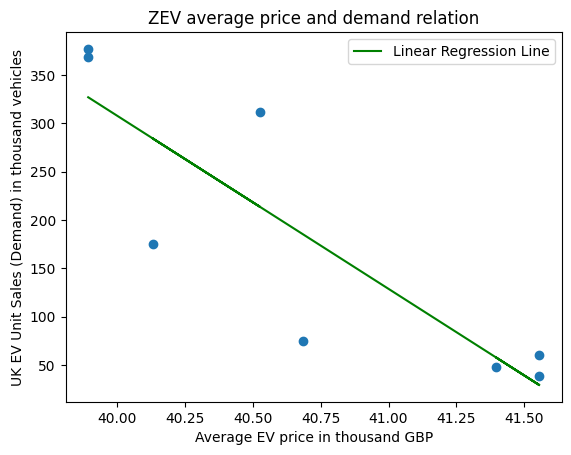

In [ ]:
import pandas as pd
import csv
import numpy as np
with open ('331Data.csv') as file:
  csvreader = csv.reader(file)
data=pd.read_csv("331Data.csv")
data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
x=np.array(data.iloc[0:8,1]).reshape((-1,1))
y=data.iloc[0:8,2]
model.fit(x,y)
#parameter of the linear regression
slope=model.coef_[0]
intercept=model.intercept_
print(slope)
print(intercept)
#visualize
plt.scatter(x,y)
y_pred = model.predict(x)
plt.plot(x, y_pred, color='green', label='Linear Regression Line')
plt.xlabel('Average EV price in thousand GBP')
plt.ylabel('UK EV Unit Sales (Demand) in thousand vehicles')
plt.title('ZEV average price and demand relation')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


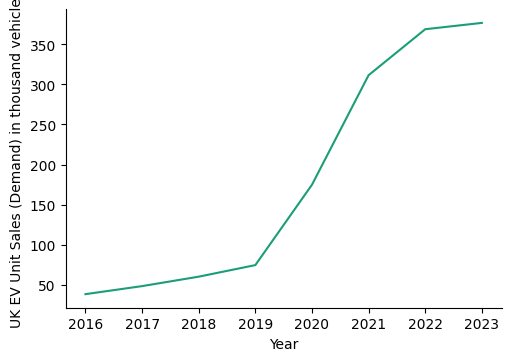

In [ ]:
# @title UK EV Unit Sales (Demand) in thousand vehicles

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['UK EV Unit Sales (Demand) in thousand vehicles']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5,3.5), layout='constrained')
df_sorted = data.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('UK EV Unit Sales (Demand) in thousand vehicles')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


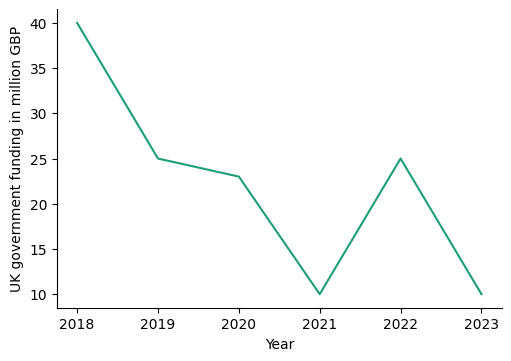

In [ ]:
# @title Year vs UK government funding in million GBP

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['UK government funding in million GBP']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5,3.5), layout='constrained')
df_sorted = data.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('UK government funding in million GBP')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


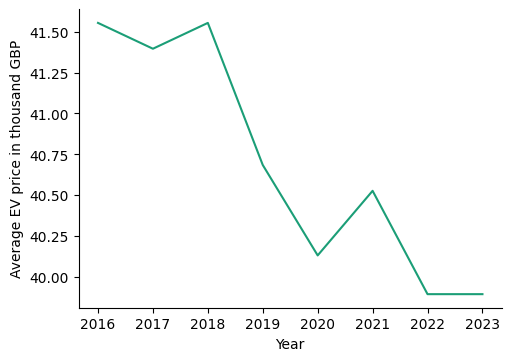

In [ ]:
# @title Year vs Average EV price in thousand GBP

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Average EV price in thousand GBP']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5, 3.5), layout='constrained')
df_sorted = data.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Average EV price in thousand GBP')

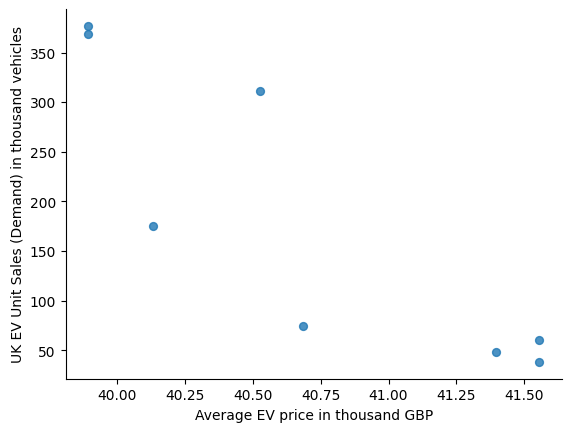

In [ ]:
# @title Average EV price in thousand GBP vs UK EV Unit Sales (Demand) in thousand vehicles

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Average EV price in thousand GBP', y='UK EV Unit Sales (Demand) in thousand vehicles', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Main (the Colab environment may not support this snippet)


The main script orchestrates the training process for a multi-agent reinforcement learning environment using the MADDPG algorithm. It sets up the environment, initializes agents, manages training episodes, evaluates policies, and plots training progress. The script handles command-line arguments to customize the training process, including episode limits, evaluation frequency, and network parameters. It demonstrates the integration of components such as the environment, MADDPG agents, and replay buffer for effective learning in a simulated market environment.

In [ ]:
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
#from marketenv import MarketEnv
import argparse
#from replay_buffer import ReplayBuffer
#from maddpg import MADDPG
import copy
from gym import spaces
import matplotlib.pyplot as plt
from datetime import datetime
import os
from tqdm import tqdm, trange


class Runner:
    def __init__(self, args, env_name, number, seed):
        self.args = args
        self.env_name = env_name
        self.number = number
        self.seed = seed
        # Create env
        self.env = MarketEnv(args.max_action)  # Continuous action space
        self.env_evaluate = MarketEnv(args.max_action)
        self.args.N = self.env.n  # The number of agents
        self.args.obs_dim_n = [self.env.observation_space[i].shape[0] for i in
                               range(self.args.N)]  # obs dimensions of N agents
        self.args.action_dim_n = [self.env.action_space[i].shape[0] for i in
                                  range(self.args.N)]  # actions dimensions of N agents
        print("observation_space=", self.env.observation_space)
        print("obs_dim_n={}".format(self.args.obs_dim_n))
        print("action_space=", self.env.action_space)
        print("action_dim_n={}".format(self.args.action_dim_n))
        timename = datetime.now().strftime("%H%M%S")
        self.result_dir = f"./training_result_{timename}"
        if not os.path.exists(self.result_dir):
            os.makedirs(self.result_dir)

        # Set random seed
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)

        # Create N agents
        self.agent_n = [MADDPG(args, agent_id) for agent_id in range(args.N)]

        self.replay_buffer = ReplayBuffer(self.args)


        # Create a tensorboard
        tensorboard_log_dir = f"./runs"
        if not os.path.exists(tensorboard_log_dir):
            os.makedirs(tensorboard_log_dir)
        self.writer = SummaryWriter(
            log_dir='runs/{}/{}_env_{}_number_{}_seed_{}'.format(self.args.algorithm, self.args.algorithm,
                                                                 self.env_name, self.number, self.seed))

        self.evaluate_rewards = []  # Record the rewards during the evaluating
        self.total_steps = 0

        self.noise_std = self.args.noise_std_init  # Initialize noise_std

    def run(self, ):
        episode_reward_record = {i: [] for i in range(self.env.n)}
        for episode in trange(self.args.train_episode):
            timestep = 0
            step_reward = {i: 0 for i in range(self.env.n)}
            step_reward_record = {i: [] for i in range(self.env.n)}
            step_action_record = {i: [] for i in range(self.env.n)}
            step_obs_record = {i: [] for i in range(self.env.n)}
            obs_n = self.env.reset()
            for _ in range(self.args.episode_limit):
                a_n = [agent.choose_action(obs, noise_std=self.noise_std) for agent, obs in zip(self.agent_n, obs_n)]
                obs_next_n, r_n, done_n, _ = self.env.step(copy.deepcopy(a_n))
                for i in range(self.env.n):
                    step_reward[i] += r_n[i]
                    step_reward_record[i].append(r_n[i])
                    step_action_record[i].append(a_n[i])
                    step_obs_record[i].append(obs_next_n[i])
                # Store the transition
                self.replay_buffer.store_transition(obs_n, a_n, r_n, obs_next_n, done_n)
                obs_n = obs_next_n
                self.total_steps += 1
                timestep += 1


                # Decay noise_std
                if self.args.use_noise_decay:
                    self.noise_std = self.noise_std - self.args.noise_std_decay if self.noise_std - self.args.noise_std_decay > self.args.noise_std_min else self.args.noise_std_min

                if self.replay_buffer.current_size > self.args.batch_size:
                    # Train each agent individually
                    for agent_id in range(self.args.N):
                        self.agent_n[agent_id].train(self.replay_buffer, self.agent_n)

                if self.total_steps % self.args.evaluate_freq == 0:
                    self.evaluate_policy()

                if all(done_n):
                    break

            # plt the reward and the action of each episode

            # reward plt
            fig, ax = plt.subplots()
            x = range(int(2018), int(timestep + 2018))
            for i in range(self.env.n):
                ax.plot(x, step_reward_record[i])
            ax.legend([f"agent{i}" for i in range(self.env.n)])
            ax.set_xlabel('Year')
            ax.set_ylabel('Reward')
            title = f'reward of episode {episode + 1}'
            ax.set_title(title)
            plt.xticks(x)
            plt.xticks(rotation=45)
            plt.savefig(os.path.join(self.result_dir, title))
            plt.close()

            # action plt
            fig, ax = plt.subplots()
            x = range(int(2018), int(timestep + 2018))
            for agent_id, action in step_action_record.items():
                ax.plot(x, action)
            ax.legend([f"agent{i}" for i in range(self.env.n)])
            ax.set_xlabel('Year')
            ax.set_ylabel('Action')
            title = f'action of episode {episode + 1}'
            ax.set_title(title)
            plt.xticks(x)
            plt.xticks(rotation=45)
            plt.savefig(os.path.join(self.result_dir, title))
            plt.close()

            # obs plt
            fig, ax = plt.subplots()
            x = range(int(2018), int(timestep + 2018))
            for agent_id, inx_obs in step_obs_record.items():
                ax.plot(x, inx_obs)
            #ax.legend([f"agent{i}" for i in range(self.env.n)])
            ax.set_xlabel('Year')
            ax.set_ylabel('Demand')
            title = f'obs of episode {episode + 1}'
            ax.set_title(title)
            plt.xticks(x)
            plt.xticks(rotation=45)
            plt.savefig(os.path.join(self.result_dir, title))
            plt.close()

            # record the episode reward
            for i in range(self.env.n):
                episode_reward_record[i].append(step_reward[i])

        # plot the episode reward figure
        fig, ax = plt.subplots()
        x = range(1, len(episode_reward_record[i]) + 1)
        for i in range(self.env.n):
            ax.plot(x, episode_reward_record[i])
        ax.legend([f"agent{i}" for i in range(self.env.n)])
        ax.set_xlabel('episode')
        ax.set_ylabel('Reward')
        title = f'Reward of training'
        ax.set_title(title)
        plt.savefig(os.path.join(self.result_dir, title))
        plt.close()



    def evaluate_policy(self):
        evaluate_reward = 0
        for _ in range(self.args.evaluate_times):
            obs_n = self.env_evaluate.reset()
            episode_reward = 0
            for _ in range(self.args.episode_limit):
                a_n = [agent.choose_action(obs, noise_std=0) for agent, obs in
                       zip(self.agent_n, obs_n)]  # We do not add noise when evaluating
                obs_next_n, r_n, done_n, _ = self.env_evaluate.step(copy.deepcopy(a_n))
                # print("a_n", a_n)
                # print("r_n", r_n)
                episode_reward += r_n[0] + r_n[1]
                obs_n = obs_next_n
                if all(done_n):
                    break
            evaluate_reward += episode_reward

        evaluate_reward = evaluate_reward / self.args.evaluate_times
        self.evaluate_rewards.append(evaluate_reward)
        self.writer.add_scalar('evaluate_step_rewards_{}'.format(self.env_name), evaluate_reward,
                               global_step=self.total_steps)
        # Save the rewards and models
        data_save_dir = "./data_train"
        if not os.path.exists(data_save_dir):
            os.makedirs(data_save_dir)
        np.save('./data_train/{}_env_{}_number_{}_seed_{}.npy'.format(self.args.algorithm, self.env_name, self.number,
                                                                      self.seed), np.array(self.evaluate_rewards))
        for agent_id in range(self.args.N):
            self.agent_n[agent_id].save_model(self.env_name, self.args.algorithm, self.number, self.total_steps,
                                              agent_id)

#calibration:

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("--train_episode", type=int, default=int(260), help="The episode of training")
    parser.add_argument("--episode_limit", type=int, default=18, help="Maximum number of steps per episode")
    parser.add_argument("--evaluate_freq", type=float, default=5000,
                        help="Evaluate the policy every 'evaluate_freq' steps")
    parser.add_argument("--evaluate_times", type=float, default=3, help="Evaluate times")
    parser.add_argument("--max_action", type=float, default=40, help="Max action")
    parser.add_argument("--algorithm", type=str, default="MADDPG", help="algorithm")
    parser.add_argument("--buffer_size", type=int, default=int(1e6), help="The capacity of the replay buffer")
    parser.add_argument("--batch_size", type=int, default=1024, help="Batch size")
    parser.add_argument("--hidden_dim", type=int, default=32,
                        help="The number of neurons in hidden layers of the neural network")
    parser.add_argument("--noise_std_init", type=float, default=0.5, help="The std of Gaussian noise for exploration")
    parser.add_argument("--noise_std_min", type=float, default=0.5, help="The std of Gaussian noise for exploration")
    parser.add_argument("--noise_decay_steps", type=float, default=500,
                        help="How many steps before the noise_std decays to the minimum")
    parser.add_argument("--use_noise_decay", type=bool, default=True, help="Whether to decay the noise_std")
    parser.add_argument("--lr_a", type=float, default=1e-2, help="Learning rate of actor")
    parser.add_argument("--lr_c", type=float, default=1e-2, help="Learning rate of critic")
    parser.add_argument("--gamma", type=float, default=0.9, help="Discount factor")
    parser.add_argument("--tau", type=float, default=0.01, help="Softly update the target network")
    parser.add_argument("--use_orthogonal_init", type=bool, default=True, help="Orthogonal initialization")
    parser.add_argument("--use_grad_clip", type=bool, default=True, help="Gradient clip")

    args = parser.parse_args()
    args.noise_std_decay = (args.noise_std_init - args.noise_std_min) / args.noise_decay_steps

    env_names = "micro game"
    runner = Runner(args, env_name=env_names, number=1, seed=0)
    runner.run()